We will explore 3 methods for bucketing:
1. Using Quantiles
2. Mean Squared Error (MSE) Optimization → Minimize squared error within buckets.
3. Log-Likelihood Optimization → Maximize the statistical likelihood of default distribution.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from itertools import combinations

In [55]:
loan_data = pd.read_csv('Task 3 and 4_Loan_Data.csv')
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [56]:
# Method 1: Using Quantiles
num_buckets = 5  
# Compute quantile-based boundaries for FICO scores
fico_quantile_bins = np.percentile(loan_data['fico_score'], np.linspace(0, 100, num_buckets + 1))
def quantile_fico_bucket(fico_score):
    for i in range(len(fico_quantile_bins) - 1):
        if fico_quantile_bins[i] <= fico_score < fico_quantile_bins[i + 1]:
            return f"Bucket {i+1}" 
loan_data['fico_quantile_bucket'] = loan_data['fico_score'].apply(quantile_fico_bucket)
loan_data[['fico_score','fico_quantile_bucket']].head()

,fico_score,fico_quantile_bucket
0,605,Bucket 2
1,572,Bucket 1
2,602,Bucket 2
3,612,Bucket 2
4,631,Bucket 3


In [57]:
# Group by fico_quantile_bucket and calculate min and max FICO score in each bucket
quantile_bucket_summary = loan_data.groupby('fico_quantile_bucket')['fico_score'].agg(['min', 'max']).reset_index()

# Display the summary table
print("FICO Quantile Bucket Boundaries (Min-Max):")
print(quantile_bucket_summary)


FICO Quantile Bucket Boundaries (Min-Max):
  fico_quantile_bucket  min  max
0             Bucket 1  408  586
1             Bucket 2  587  622
2             Bucket 3  623  652
3             Bucket 4  653  687
4             Bucket 5  688  835


In [58]:
# # Method 2: Kmeans
# from sklearn.cluster import KMeans
# num_buckets = 5

# fico_scores = loan_data[['fico_score']].values.reshape(-1, 1)

# # Apply K-Means clustering to optimize FICO score buckets
# kmeans = KMeans(n_clusters=num_buckets, random_state=42, n_init=10)
# loan_data['fico_cluster'] = kmeans.fit_predict(fico_scores)

# # Compute the Mean Squared Error (MSE) for each cluster
# mse_per_cluster = {}
# for cluster in range(num_buckets):
#     cluster_data = loan_data[loan_data['fico_cluster'] == cluster]['fico_score']
#     mse = np.mean((cluster_data - cluster_data.mean())**2)
#     mse_per_cluster[f'Bucket {cluster+1}'] = round(mse, 2)

# mse_per_cluster

In [59]:


# Define the Greedy MSE Bucketing Function
def greedy_mse_bucketing(fico_scores, default_labels, n_buckets=5):
    df = pd.DataFrame({'fico': fico_scores, 'default': default_labels})
    df = df.sort_values('fico').reset_index(drop=True)

    splits = [0, len(df)]
    while len(splits) - 1 < n_buckets:
        best_split = None
        best_mse = float('inf')
        for i in range(len(splits) - 1):
            start, end = splits[i], splits[i + 1]
            for j in range(start + 1, end):
                temp_splits = splits[:i+1] + [j] + splits[i+1:]
                mse = 0
                for k in range(len(temp_splits) - 1):
                    y_true = df['default'].iloc[temp_splits[k]:temp_splits[k+1]]
                    y_pred = np.full_like(y_true, y_true.mean(), dtype=float)
                    mse += mean_squared_error(y_true, y_pred) * len(y_true)
                mse /= len(df)
                if mse < best_mse:
                    best_mse = mse
                    best_split = j
        if best_split is not None:
            splits.append(best_split)
            splits = sorted(splits)
        else:
            break

    df['credit_rating'] = 0
    for i in range(len(splits) - 1):
        df.loc[splits[i]:splits[i+1]-1, 'credit_rating'] = i + 1

    return df[['fico', 'default', 'credit_rating']], best_mse

# Apply the function to the dataset
result_df, mse = greedy_mse_bucketing(loan_data['fico_score'], loan_data['default'], n_buckets=5)



In [60]:
# Show MSE value
print("MSE after greedy bucketing:", round(mse, 4))

# Show the first few rows of the result
print(result_df.head(10))
loan_data['credit_rating'] = result_df['credit_rating']

MSE after greedy bucketing: 0.133
   fico  default  credit_rating
0   408        0              1
1   409        1              1
2   418        1              1
3   425        1              1
4   438        1              1
5   440        1              1
6   441        1              1
7   444        0              1
8   447        0              1
9   449        1              1


In [61]:
def extract_bucket_boundaries(fico_scores, credit_ratings):
    df = pd.DataFrame({'fico': fico_scores, 'rating': credit_ratings})
    boundaries = df.groupby('rating')['fico'].agg(['min', 'max']).reset_index()
    return boundaries

# Get FICO boundaries for each rating bucket
boundaries_df = extract_bucket_boundaries(result_df['fico'], result_df['credit_rating'])

# Show the result
print("\n📊 FICO Score Boundaries for Each Credit Rating:")
print(boundaries_df)


📊 FICO Score Boundaries for Each Credit Rating:
   rating  min  max
0       1  408  521
1       2  521  580
2       3  580  611
3       4  611  640
4       5  640  850


In [62]:
# Method 3: Log-Likelihood Optimization for FICO Score Bucketing


from scipy.optimize import minimize

# Prepare data: Count defaults and total borrowers per FICO score
fico_default_counts = loan_data.groupby('fico_score')['default'].sum()  # Number of defaults per score
fico_total_counts = loan_data.groupby('fico_score')['default'].count()  # Total borrowers per score

# Remove missing data points (if any)
valid_fico_scores = fico_default_counts.index.intersection(fico_total_counts.index)
fico_default_counts = fico_default_counts.loc[valid_fico_scores]
fico_total_counts = fico_total_counts.loc[valid_fico_scores]

# Compute default probabilities per FICO score
default_probabilities = fico_default_counts / fico_total_counts

# Define the Log-Likelihood function to optimize
def log_likelihood(buckets):
    """
    Computes the negative log-likelihood for a given set of FICO score bucket boundaries.

    Parameters:
    - buckets (list): FICO score bucket boundaries.

    Returns:
    - float: Negative log-likelihood value (to be minimized).
    """
    buckets = sorted([300] + list(buckets) + [850])  # Ensure bounds from 300 to 850
    likelihood = 0

    # Loop over each bucket and compute its contribution to the likelihood
    for i in range(len(buckets) - 1):
        lower, upper = buckets[i], buckets[i + 1]
        bucket_mask = (valid_fico_scores >= lower) & (valid_fico_scores < upper)

        n_i = fico_total_counts[bucket_mask].sum()  # Total loans in bucket
        k_i = fico_default_counts[bucket_mask].sum()  # Defaults in bucket

        # Avoid log(0) issues
        if n_i > 0 and k_i > 0:
            p_i = k_i / n_i  # Default probability in bucket
            likelihood += k_i * np.log(p_i) + (n_i - k_i) * np.log(1 - p_i)

    return -likelihood  # Minimize negative log-likelihood

# Optimize bucket boundaries using log-likelihood maximization
initial_buckets = np.linspace(300, 850, 5)[1:-1]  # Initial guesses for bucket boundaries
opt_result = minimize(log_likelihood, initial_buckets, method='Nelder-Mead')

# Get optimized bucket boundaries
optimized_buckets = sorted([300] + list(opt_result.x) + [850])

# Assign each borrower's FICO score to an optimized bucket
def assign_optimized_bucket(fico_score):
    for i in range(len(optimized_buckets) - 1):
        if optimized_buckets[i] <= fico_score < optimized_buckets[i + 1]:
            return f"Bucket {i+1}"

loan_data['optimized_fico_bucket'] = loan_data['fico_score'].apply(assign_optimized_bucket)

optimized_buckets


[300,
 np.float64(499.88251990022667),
 np.float64(580.4327127497354),
 np.float64(649.2303445833217),
 850]

Compare Default Rates Across Bucketsm

In [63]:
default_rate_quantile = loan_data.groupby('fico_quantile_bucket')['default'].mean()
default_rate_mse = loan_data.groupby('credit_rating')['default'].mean()
default_rate_log_likelihood = loan_data.groupby('optimized_fico_bucket')['default'].mean()


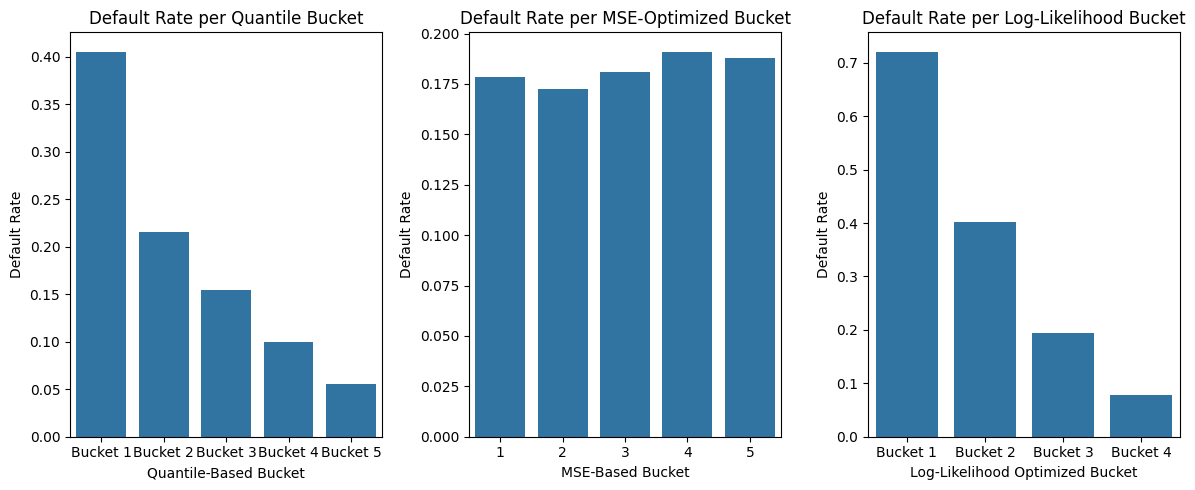

In [64]:
plt.figure(figsize=(12, 5))

# Plot Quantile-Based Bucketing Default Rates
plt.subplot(1, 3, 1)
sns.barplot(x=default_rate_quantile.index, y=default_rate_quantile.values)
plt.title("Default Rate per Quantile Bucket")
plt.xlabel("Quantile-Based Bucket")
plt.ylabel("Default Rate")
# Plot MSE-Based Bucketing Default Rates
plt.subplot(1, 3, 2)
sns.barplot(x=default_rate_mse.index.astype(str), y=default_rate_mse.values)
plt.title("Default Rate per MSE-Optimized Bucket")
plt.xlabel("MSE-Based Bucket")
plt.ylabel("Default Rate")

# Plot Log-Likelihood Optimized Bucketing Default Rates
plt.subplot(1, 3, 3)
sns.barplot(x=default_rate_log_likelihood.index, y=default_rate_log_likelihood.values)
plt.title("Default Rate per Log-Likelihood Bucket")
plt.xlabel("Log-Likelihood Optimized Bucket")
plt.ylabel("Default Rate")

plt.tight_layout()
plt.show()

In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 1: Select features and label
X = loan_data[['fico_score', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'credit_lines_outstanding']]
y = loan_data['default']

# Step 2: Fit LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda_score = lda.fit_transform(X, y)

# Step 3: Add LDA score to your data
loan_data['lda_score'] = lda_score  # this becomes a Series already

# ✅ Step 4: Bucket the LDA scores — no flatten() needed here!
loan_data['lda_bucket'] = pd.qcut(loan_data['lda_score'], q=5, labels=[1, 2, 3, 4, 5])

# Step 5: Check default rate per bucket
bucket_default_rate = loan_data.groupby('lda_bucket')['default'].mean()
print(bucket_default_rate)


lda_bucket
1    0.0000
2    0.0000
3    0.0000
4    0.0010
5    0.9245
Name: default, dtype: float64


/var/folders/57/lkbzvbp92nv6k9m7r10l7d3w0000gn/T/ipykernel_35032/2301505559.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_default_rate = loan_data.groupby('lda_bucket')['default'].mean()
